In [68]:
from torch import nn, optim
import os
import shapely
import pandas as pd
import geopandas as gpd
import numpy as np
from numpy.random import default_rng
import torch
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import libpysal
import matplotlib.pyplot as plt
from copy import deepcopy

In [25]:
def load_data(year):
    os.getcwd()
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    for filename in os.listdir(path):
        df1 = pd.read_csv(path + filename)
        if df1.geometry.isna().any():
            print(filename)
        df = pd.concat([df, df1])
    df = gpd.GeoDataFrame(df)
    df.geometry = df.geometry.apply(shapely.wkt.loads)
    
    df = df.reset_index()
    df = df.drop(["Unnamed: 0", "index"], axis = 1)
    return df

In [26]:
def create_CNN_samples(grid, block, dims = 39):
    
    nonzero = np.transpose(grid[:,:,-2].nonzero()) # Get indices of nonzero componetns
    size = nonzero.shape[0]
    width = block * 2 + 1 # calculate widht and height. Needed later on
    
    X = np.zeros((size, width, width, dims))
    Y = np.zeros(size)
    ID = np.zeros(size)
    Y_1 = np.zeros(size)
    
    for idx, i in enumerate(nonzero):
        x, ID[idx], Y[idx], Y_1[idx] = get_neighbor_grid(grid, i, block)
        X[idx] = x.reshape(width,width, dims)
        
    X = np.moveaxis(X, -1, 1) # order the indices correctly to make sure it works in CNN
    X = torch.from_numpy(X).float()
    Y = torch.from_numpy(Y).float()
    
    return X,ID,Y, Y_1

In [27]:
def get_neighbor_grid(full, hw, block = 1):
    
    # get the nonzero (built) blocks by checking if they have a ID

    h = hw[0]
    w = hw[1]
    
    y = full[h,w,-1]
    ID = full[h,w,-2]
    Y_1_train = full[h,w,-3]
    
    hu = h - block
    hd = h + block
    hshort, hextra, wshort, wextra = 0,0,0,0
    if hu < 0:
        hshort = 0 - hu
        hu = 0
    if hd >= full.shape[0]:
        hextra = (hd - full.shape[0]) + 1
        hd = full.shape[0]

    wr = w + block
    wl = w - block

    if wr >= full.shape[1]:
        wextra = (wr - full.shape[1]) + 1
        wr = full.shape[1]
    if wl < 0:
        wshort = 0 - wl
        wl = 0

    nb = full[hu : hd + 1, wl : wr + 1, :]
    nb = np.pad(nb, ((hshort, hextra), (wshort, wextra), (0,0)), mode = "constant", constant_values = 0)
    return nb[:,:,:-3], ID, y, Y_1_train


In [28]:
import torch
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("Device: {}".format(device))

Device: cpu


In [29]:
df15 = load_data(2015).set_index("C28992R100")
df16 = load_data(2016).set_index("C28992R100")
df17 = load_data(2017).set_index("C28992R100")
df18 = load_data(2018).set_index("C28992R100")
df19 = load_data(2019).set_index("C28992R100")


In [30]:
# Get data that is available in all years
overlapping1517 = df17.index[df17.index.isin(df16.index[df16.index.isin(df15.index)])]
overlapping1518 = df18.index[df18.index.isin(overlapping1517)]
overlapping1519 = df19.index[df19.index.isin(overlapping1518)]




In [31]:
import pickle
with open("cbs_id_koppel.pickle", "rb") as f:
    a = pickle.load(f)
overlap_num = [a[x] for x in overlapping1519]

In [53]:
def get_cnn_time(year, overlap_num):
    X_train = []
    Y_train = []
    ID_train = []
    Y_1_train = []
    for filename in os.listdir("../Data/filled/grids/" + str(year) + "/"):
        n = np.load("../Data/filled/grids/" + str(year) + "/" + filename)
        X, ID, Y, Y_1 = create_CNN_samples(n, 10)
        X_train.append(X)
        Y_train.append(Y)
        ID_train.append(ID)
        Y_1_train.append(Y_1)

    Y = np.concatenate(Y_train)
    ID = np.concatenate(ID_train)
    X = np.concatenate(X_train)
    Y1 = np.concatenate(Y_1_train)
    overlap = np.isin(ID, overlap_num)
    return X[overlap], Y[overlap], ID[overlap], Y1[overlap]

    
# X15c, Y15c, ID15c, Y115c = get_cnn_time(2015, overlap_num)
# X16c, Y16c, ID16c, Y116c = get_cnn_time(2016, overlap_num)
# X17c, Y17c, ID17c, Y117c = get_cnn_time(2017, overlap_num)
# X18c, Y18c, ID18c, Y118c = get_cnn_time(2018, overlap_num)
# X19c, Y19c, ID19c, Y119c = get_cnn_time(2019, overlap_num)


In [54]:
# Fill X and Y
block_size = get_cnn_time(2015, overlap_num)[0].shape[-1]
X = np.zeros((len(overlapping1519), 5, 39, block_size, block_size))
Y = np.zeros((len(overlapping1519), 5))
Y_1 = np.zeros((len(overlapping1519), 5))
ID = np.zeros((len(overlapping1519), 5))
ss = StandardScaler()


for i, year in enumerate([2015, 2016, 2017, 2018, 2019]):
    X[:,i], Y[:,i], ID[:,i], Y_1[:,i] = get_cnn_time(year, overlap_num)

In [55]:
# Create neighbor lists for all years

df15 = df15.loc[overlapping1519]
df16 = df16.loc[overlapping1519]
df17 = df17.loc[overlapping1519]
df18 = df18.loc[overlapping1519]
df19 = df19.loc[overlapping1519]


w15 = libpysal.weights.DistanceBand.from_dataframe(df15.reset_index(), threshold=150, binary = True, silence_warnings = True)
w16 = libpysal.weights.DistanceBand.from_dataframe(df16.reset_index(), threshold=150, binary = True, silence_warnings = True)
w17 = libpysal.weights.DistanceBand.from_dataframe(df17.reset_index(), threshold=150, binary = True, silence_warnings = True)
w18 = libpysal.weights.DistanceBand.from_dataframe(df18.reset_index(), threshold=150, binary = True, silence_warnings = True)
w19 = libpysal.weights.DistanceBand.from_dataframe(df19.reset_index(), threshold=150, binary = True, silence_warnings = True)

In [56]:
# create Y(t-1) for all years

def get_y_1(y1, w):
    neighbors = [w.neighbors[x] for x in w.neighbors]
    y1 = np.array([y1[x].sum() for x in neighbors])
    y1[np.where(y1 == 0)[0]] = 0.5

    return y1

Y1_15 = get_y_1(Y_1[:,0], w15)
Y1_16 = get_y_1(Y_1[:,1], w16)
Y1_17 = get_y_1(Y_1[:,2], w17)
Y1_18 = get_y_1(Y_1[:,3], w18)
Y1_19 = get_y_1(Y_1[:,4], w19)



In [57]:
# X train is the first three years
X_train = X[:,:3]
Y_train = Y[:,2]

X_train = np.moveaxis(X_train, 2 ,-1)
X_train = X_train.reshape(-1, 39)
X_train = ss.fit_transform(X_train)
X_train = np.append(X_train.reshape(Y1_17.shape[0], -1), Y1_17.reshape(-1,1), axis = 1)

In [58]:
smote = SMOTE()
X_train_resample,Y_train_resample = smote.fit_resample(X_train,Y_train)

Y1_17r = X_train_resample[:,-1]
Y1_17r[Y1_17r>0.5] =  np.ceil(Y1_17r[Y1_17r > 0.5])

X_train_resample = np.delete(X_train_resample, -1, -1)
X_train_resample = X_train_resample.reshape(X_train_resample.shape[0], 3, block_size, block_size, 39)
X_train_resample = np.moveaxis(X_train_resample, -1, 2)

In [59]:
X_val = X[:,:4]
Y_val = Y[:,3]
X_val = np.moveaxis(X_val, 2, -1)
X_val = X_val.reshape(-1, 39)
X_val = ss.transform(X_val)
X_val = X_val.reshape(Y_val.shape[0], 4, block_size, block_size, 39)
X_val = np.moveaxis(X_val, -1, 2)

X_val = torch.tensor(X_val).float()
X_train_resample = torch.tensor(X_train_resample).float()
Y_train_resample = torch.tensor(Y_train_resample).float()
Y1_17r = torch.tensor(Y1_17r).float()
Y1_18 = torch.tensor(Y1_18).float()

In [60]:
X_test = X[:,:5]
Y_test = Y[:,4]
X_test = np.moveaxis(X_test, 2, -1)
X_test = X_test.reshape(-1, 39)
X_test = ss.transform(X_test)
X_test = X_test.reshape(Y_test.shape[0], 5, block_size, block_size, 39)
X_test = np.moveaxis(X_test, -1, 2)
X_test = torch.tensor(X_test).float()
Y1_19 = torch.tensor(Y1_19).float()

In [61]:
rng = default_rng()
def get_batch(X, Y, Y1, batch_size = 32):
    idxs = rng.integers(len(X), size = batch_size)
    return X[idxs], Y[idxs], Y1[idxs]



In [69]:
class RNNCNN(nn.Module): # auc: 0.692
    def __init__(self):
        super(RNNCNN, self).__init__()
        self.conv = nn.Sequential(
             nn.Conv2d(in_channels= 39, out_channels = 15, kernel_size = (4,4)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 15, out_channels = 2, kernel_size = (4,4)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Flatten()
         
        )
        self.GRU = nn.GRU(input_size = 57 ,hidden_size = 100, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(100,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,1)
        )
        self.final = nn.Sigmoid()
        
    def forward(self, X, Y1):
        orig = X[:,:,:,10,10] # original cells are at the center of 11*11 point
        
        batch_size, timesteps, C, H, W = X.size()
        
        c_in = X.view(batch_size * timesteps, C, H, W)
        c_out = self.conv(c_in)
        
        # reshape and concatenate the original data
        r_in = c_out.view(batch_size, timesteps, -1)
        r_in = torch.cat((orig, r_in), axis = 2)
        
        h0 = torch.zeros(1, X.size(0), 100).to(device)
        
        X, _ = self.GRU(r_in, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X


In [70]:
model = RNNCNN()

In [71]:
def train(model, X_train, Y_train, Y1_train, X_val, Y_val, Y1_val, num_epochs,lr, batch_per_e =100 ):
    
    train_loss = []
    train_loss_history = []
    acc_history = []
    ROC_history = []
    f1_score_history = []
    val_loss_history = []
    best_auc = 0
    best_f1 = 0
    best_model = np.NaN



    optimizer = optim.RMSprop(model.parameters(), lr = lr) 
    SigBCEloss = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        print(epoch)
        epoch_loss = []
        for batch in range(batch_per_e):
            x, y, y1 = get_batch(X_train, Y_train, Y1_train, 6)

            model.train()
            optimizer.zero_grad()
            out = model(x, y1).squeeze()
            loss = SigBCEloss(out, y)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.cpu().detach().numpy())

        model.eval()
        out = model(X_val, Y1_val) 
        ROC = roc_auc_score(Y_val, model.final(out).detach())
        val_loss = SigBCEloss(out, torch.tensor(Y_val).float())
        preds = np.zeros(len(out))
        pos = out.argsort()[-((Y_val == 1).sum()):]
        preds[pos] = 1

        f1 = f1_score(Y_val, preds)

        acc = accuracy_score(Y_val, preds)

        if ROC > best_auc:
            print(ROC, f1)
            best_auc = ROC
            best_model = deepcopy(model.state_dict())
            



        acc_history.append(acc)
        ROC_history.append(ROC)
        train_loss_history.append(np.sum(epoch_loss) / batch_per_e)
        f1_score_history.append(f1)
        val_loss_history.append(val_loss.detach().numpy())

    plt.plot(train_loss_history, alpha = 0.5)
    plt.hlines(np.mean(train_loss_history), 0, n_epochs, color = "r")
    plt.plot(val_loss_history, alpha = 0.5, color = "green")
    plt.show()


    plt.plot(ROC_history, alpha = 0.5)
    plt.hlines(np.mean(ROC_history), 0, n_epochs, color = "r")
    plt.show()

    train_loss = []
    print(out)
    result = np.argmax(ROC_history)
    print("best auc: {}, f1: {}, epoch: {}".format(ROC_history[result], f1_score_history[result], result))
    return acc_history, ROC_history, train_loss_history, f1_score_history, val_loss_history, best_model

0
0.4175615876888832 0.13141025641025642
1
0.441331929640569 0.14807692307692308
2
0.46233318886177815 0.17564102564102563
3
0.4939833393975715 0.19038461538461537
4
0.5281678063867129 0.21794871794871795
5
0.5604646009017878 0.25064102564102564
6
0.5786761322289286 0.2608974358974359
7
0.5904502518442418 0.2685897435897436
8
0.6007588769744445 0.2724358974358974
9
0.6094322535422286 0.2814102564102564
10
0.617802284434171 0.28846153846153844
11
0.6224276482884581 0.28974358974358977
12
0.6262140069631721 0.2923076923076923
13
0.6313023932337372 0.2935897435897436
14
0.6360073056233324 0.29615384615384616
15
0.6381197562176276 0.29615384615384616
16
0.6406806483027268 0.2987179487179487
17
0.6439390169513292 0.30256410256410254
18
0.6463509784826562 0.30448717948717946
19
0.6488341502218798 0.30705128205128207
20
0.6499452880869826 0.30641025641025643
21
0.6512165931823695 0.308974358974359
22
0.6525910349157428 0.308974358974359
23
0.6539972693092476 0.3096153846153846
24
0.6554087207

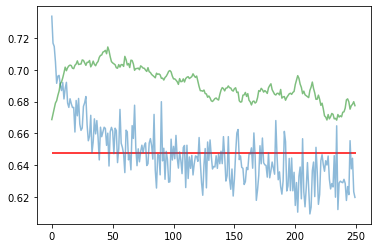

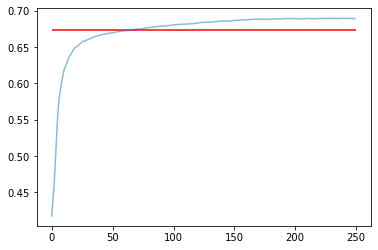

tensor([-0.2783, -0.2159, -0.2849,  ..., -0.1654, -0.3610, -0.2910],
       grad_fn=<MulBackward0>)
best auc: 0.6894882674828418, f1: 0.34935897435897434, epoch: 241


In [72]:
n_epochs = 250
hists = train(model, X_train_resample, Y_train_resample, Y1_17r, X_val, Y_val, Y1_18, n_epochs,5.1e-06)



In [75]:
hists

([0.6902149062642889,
  0.696159122085048,
  0.7059899405578418,
  0.7112482853223594,
  0.7210791037951532,
  0.7327389117512574,
  0.7363968907178784,
  0.7391403749428441,
  0.7405121170553269,
  0.7437128486511203,
  0.7462277091906722,
  0.7466849565614998,
  0.747599451303155,
  0.7480566986739826,
  0.7489711934156379,
  0.7489711934156379,
  0.7498856881572931,
  0.751257430269776,
  0.7519433013260174,
  0.7528577960676726,
  0.7526291723822588,
  0.7535436671239141,
  0.7535436671239141,
  0.7537722908093278,
  0.7542295381801555,
  0.7533150434385002,
  0.7537722908093278,
  0.7546867855509831,
  0.7556012802926383,
  0.7556012802926383,
  0.7558299039780522,
  0.7549154092363969,
  0.7562871513488797,
  0.7562871513488797,
  0.7556012802926383,
  0.7565157750342936,
  0.757201646090535,
  0.757201646090535,
  0.757201646090535,
  0.7565157750342936,
  0.7562871513488797,
  0.7567443987197073,
  0.7569730224051212,
  0.7567443987197073,
  0.7565157750342936,
  0.756973022405


# test

In [77]:
model = RNNCNN()
model.load_state_dict(hists[-1])
model.eval()

out = model(X_test, Y1_19)

ROC = roc_auc_score(Y_test, model.final(out).detach().numpy())
out = out.squeeze().detach().numpy()

preds = np.zeros(len(out))
pos = out.argsort()[-((Y_test == 1).sum()):]
preds[pos] = 1

f1 = f1_score(Y_test, preds)
print(ROC, f1)
with open ("../Results/Denhaag.csv", "a+") as f:
    f.write("\nRNNCNN,{},{}".format(ROC,f1))

0.6649099455596326 0.38922764227642276


X_val


In [ ]:
class RNNCNN(nn.Module): # auc: 0.692
    def __init__(self):
        super(RNNCNN, self).__init__()
        self.conv = nn.Sequential(
             nn.Conv2d(in_channels= 39, out_channels = 15, kernel_size = (4,4)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 15, out_channels = 2, kernel_size = (4,4)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Flatten()
         
        )
        self.GRU = nn.GRU(input_size = 57 ,hidden_size = 100, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(100,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,1)
        )
        self.final = nn.Sigmoid()
        
    def forward(self, X, Y1):
        orig = X[:,:,:,10,10] # original cells are at the center of 11*11 point
        
        batch_size, timesteps, C, H, W = X.size()
        
        c_in = X.view(batch_size * timesteps, C, H, W)
        c_out = self.conv(c_in)
        
        # reshape and concatenate the original data
        r_in = c_out.view(batch_size, timesteps, -1)
        r_in = torch.cat((orig, r_in), axis = 2)
        
        h0 = torch.zeros(1, X.size(0), 100).to(device)
        
        X, _ = self.GRU(r_in, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X
